# Exploratory Data Analysis and Model Creation

References:
- https://github.com/TungPhung/Twitter-Natural-Disaster-Mapping
- https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
- https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
- https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af

In [1]:
# !pip install pandas-profiling

In [40]:
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import regex as re
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Code to display all the columns and rows
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

### EDA - Data from CrisisLex

In [4]:
# Read data from combined disaster training file
df = pd.read_csv("../datasets/train_disasters.csv")

In [5]:
df.head()

,tweet id,tweet,label,disaster
0,'336908711324962817',@HeatleyJheat44 its barley even raining where ...,on-topic,tornado
1,'337052158035890176',Sorry I can't do anything right.,off-topic,tornado
2,'339338021751103488',@mrwendell29: @BradSowderWX says we have the ...,on-topic,tornado
3,'336339509077762051',#honestyhour I like to wear half split running...,off-topic,tornado
4,'337734129972035584',I'm too stressed to have a good summer,off-topic,tornado


In [7]:
# Replace disaster category in "disaster" column if "label" column row is "off-topic"
for i in range(len(df["disaster"])):
    if df["label"][i] == "off-topic":
        df["disaster"][i] = "off-topic"
    else:
        pass    

In [8]:
df["disaster"].value_counts()

off-topic    9782
hurricane    6138
tornado      4827
flood         768
fire          685
Name: disaster, dtype: int64

In [9]:
df.shape

(22200, 4)

In [10]:
# Remove all non-unique tweets
df.drop_duplicates(subset="tweet", inplace=True)

In [11]:
df.shape

(20873, 4)

In [98]:
list(set(df['disaster']))

['off-topic', 'fire', 'hurricane', 'flood', 'tornado']

In [122]:
pandas_profiling.ProfileReport(df)

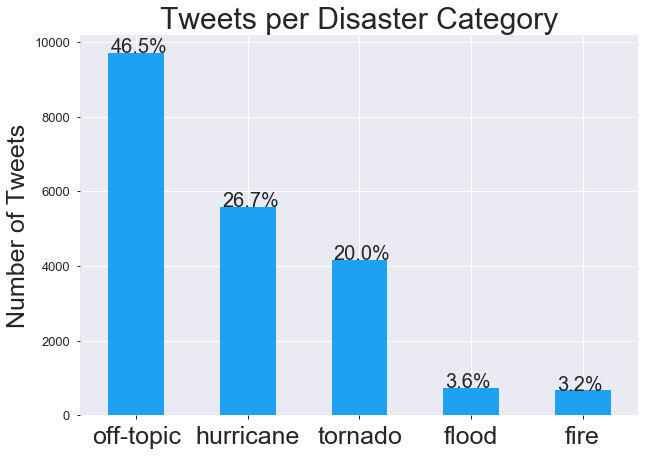

In [261]:
# Referred to code from 
# https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

ax = df['disaster'].value_counts().plot(kind='bar', figsize=(10,7), color="#1DA1F2", fontsize=13);

ax.set_title("Tweets per Disaster Category", fontsize=30)
ax.set_ylabel("Number of Tweets", fontsize=25)
ax.set_xticklabels(['off-topic','hurricane', 'tornado', 'flood', 'fire'],rotation=0, fontsize=25);


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.02, i.get_height()+.5, str(round((i.get_height()/total)*100, 1))+'%', \
            fontsize=20)

## Model Creation

### Word2Vec

Training Model on CrisisLex data

In [124]:
# Set X and y values
X = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['tweet'].copy()
y = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['disaster'].copy()

In [18]:
# Import stop words
from nltk.corpus import stopwords # Import the stop word list
english_stop_words = set(stopwords.words('english'))

In [125]:
# Function to create a nested list of tokenized words for each tweet

def clean_tweets(tweets_column):
    tweets_tokens = []
    for tweet in tweets_column:  
        if tweet not in english_stop_words:

            # regex ref: https://www.machinelearningplus.com/python/python-regex-tutorial-examples/
            tweets = re.sub('http\S+\s*', '', tweet)

            tokenizer = RegexpTokenizer('[a-zA-Z]\w+')
            tweet_tokens = tokenizer.tokenize(tweets.lower())
            tweets_tokens.append(tweet_tokens)
    return tweets_tokens

In [126]:
X = clean_tweets(X)

In [127]:
X[:5]

[['heatleyjheat44', 'its', 'barley', 'even', 'raining', 'where', 'at', 'lol'],
 ['sorry', 'can', 'do', 'anything', 'right'],
 ['mrwendell29',
  'bradsowderwx',
  'says',
  'we',
  'have',
  'the',
  'risk',
  'of',
  'severe',
  'weather',
  'everyday',
  'this',
  'week',
  'another',
  'risk',
  'for',
  'tornadoes',
  'ughh',
  'you',
  'said',
  'it'],
 ['honestyhour',
  'like',
  'to',
  'wear',
  'half',
  'split',
  'running',
  'shorts',
  'without',
  'the',
  'liner',
  'often',
  'in',
  'public',
  'my',
  'friends',
  'almost',
  'gave',
  'me',
  'an',
  'intervention'],
 ['too', 'stressed', 'to', 'have', 'good', 'summer']]

In [128]:
y.value_counts()

off-topic    9710
hurricane    5579
tornado      4168
Name: disaster, dtype: int64

In [129]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [130]:
# Code from lecture 8.07-lesson-word_vectors
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# Instantiate a model
w2v = Word2Vec(X,     # Corpus of data.
               size=100,    # How many dimensions do you want in your word vector?
               window=5,    # How many "context words" do you want?
               min_count=2, # Ignores words below this threshold.
               sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
               workers=4,   # Number of "worker threads" to use (parallelizes process).
               hs=1, 
               negative=0);   

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [131]:
w2v.vector_size

100

In [191]:
w2v.most_similar("hurricane", topn=15)

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('grease', 0.6294353008270264),
 ('crazy', 0.5532630681991577),
 ('frankenstorm', 0.5442983508110046),
 ('portal', 0.5377262234687805),
 ('twitter', 0.5006821751594543),
 ('pics', 0.49836838245391846),
 ('happy_gilmore', 0.4959239661693573),
 ('as', 0.4938969612121582),
 ('intense', 0.4615463316440582),
 ('spooky', 0.4553093910217285),
 ('storm', 0.45471736788749695),
 ('batcave', 0.45006316900253296),
 ('intensifies', 0.44616466760635376),
 ('heads', 0.44570595026016235),
 ('ass', 0.44249194860458374)]

In [192]:
w2v.most_similar("tornado", topn=15)

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('twister', 0.7776492834091187),
 ('okla', 0.7620190382003784),
 ('dead', 0.7578803300857544),
 ('yesterday', 0.753004789352417),
 ('moore', 0.7523834705352783),
 ('tornadoes', 0.7366892099380493),
 ('worldwide', 0.7126064300537109),
 ('among', 0.7001399993896484),
 ('gr4sshopp3r', 0.6973611116409302),
 ('workers', 0.6781762838363647),
 ('response', 0.673595666885376),
 ('support', 0.6707808971405029),
 ('ap', 0.6707252264022827),
 ('including', 0.6650863885879517),
 ('oklahoma', 0.663838803768158)]

### Create Model - CountVectorizer and Logistic Regression

In [143]:
# Set X and y values
X = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['tweet'].copy()
y = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['disaster'].copy()

In [144]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [17]:
# Found an article on how to use a Lemmatizer function within CountVectorizer at 
# https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af
import spacy

# Create a spaCy tokenizer
spacy.load('en_core_web_sm')
lemmatizer = spacy.lang.en.English()

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

In [16]:
# Found a post on how to add to the stop words list 
# https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS
stop_words = text.ENGLISH_STOP_WORDS.union('"', ',', '-', '.', '(', ')')

In [145]:
# Create pipeline with CountVectorizer and LogisticRegression
pipe_cv_lg = Pipeline([('cvec', CountVectorizer()), ('lg', LogisticRegression())])

In [227]:
pipe_cv_lg = Pipeline([('cvec', CountVectorizer(
                                                max_features=3000,
                                                min_df = 2,
                                                ngram_range = (1,2),
                                                stop_words = english_stop_words,
                                                tokenizer = None
                                                )), ('lg', LogisticRegression(solver='liblinear', multi_class='ovr'))])
pipe_cv_lg.fit(X_train, y_train);

In [147]:
pipe_cv_lg.score(X_train, y_train)

0.9577850877192983

In [148]:
pipe_cv_lg.score(X_test, y_test)

0.9251798561151079

In [149]:
pred = pipe_cv_lg.predict(X_test)

In [150]:
# Build a confusion matrix
cm = confusion_matrix(y_test, pred)

In [151]:
y_test.value_counts()

off-topic    2428
hurricane    1395
tornado      1042
Name: disaster, dtype: int64

In [152]:
# Referred to 
# https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
np.array(np.unique(pred, return_counts=True)).T

array([['hurricane', 1377],
       ['off-topic', 2451],
       ['tornado', 1037]], dtype=object)

In [153]:
cm_df = pd.DataFrame(cm, columns=['pred hurricane', 'pred off-topic', 'pred tornado'], 
                     index=['actual hurricane', 'actual off-topic', 'actual tornado'])
cm_df

,pred hurricane,pred off-topic,pred tornado
actual hurricane,1292,100,3
actual off-topic,79,2262,87
actual tornado,6,89,947


In [154]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

   hurricane       0.94      0.93      0.93      1395
   off-topic       0.92      0.93      0.93      2428
     tornado       0.91      0.91      0.91      1042

    accuracy                           0.93      4865
   macro avg       0.92      0.92      0.92      4865
weighted avg       0.93      0.93      0.93      4865



In [229]:
# Fit the model on the entire dataset
pipe_cv_lg.fit(X, y);

### Exploration of Logistic Regression Features

In [194]:
cv_lg_df = pd.DataFrame(pipe_cv_lg['lg'].coef_, columns=pipe_cv_lg['cvec'].get_feature_names()).transpose()
cv_lg_df.head()

,0,1,2
00,0.009889,0.333068,-0.351502
00 humidity,-0.279203,0.038071,0.130895
000,-0.742591,-0.130306,0.539865
10,-0.499845,0.619826,-0.461561
10 donation,0.043029,-0.329288,0.253616


In [195]:
cv_lg_df.columns = ['hurricane_coef', 'off-topic_coef', 'tornado_coef']                         
cv_lg_df.sort_values(by=['hurricane_coef'], ascending=False).head(15)

,hurricane_coef,off-topic_coef,tornado_coef
hurricane,6.124944,-5.515694,-3.081358
hurricanesandy,4.483616,-4.339158,-0.768149
frankenstorm,4.445786,-3.939280,-1.263087
sandy,4.442245,-4.117390,-0.990367
storm,3.673336,-3.460601,0.689464
power,3.197192,-2.869555,-0.718893
hurricanes,2.871049,-3.138435,0.000866
evacuate,2.845862,-2.730503,-0.113967
electricity,2.433705,-2.300247,-0.171985
powers,2.420478,-2.069714,-0.343224


In [196]:
# Calculate the probability that the word "frankenstorm" indicates a hurricane tweet
(np.exp(4.445786) / (1+np.exp(4.445786)))

0.9884080645870024

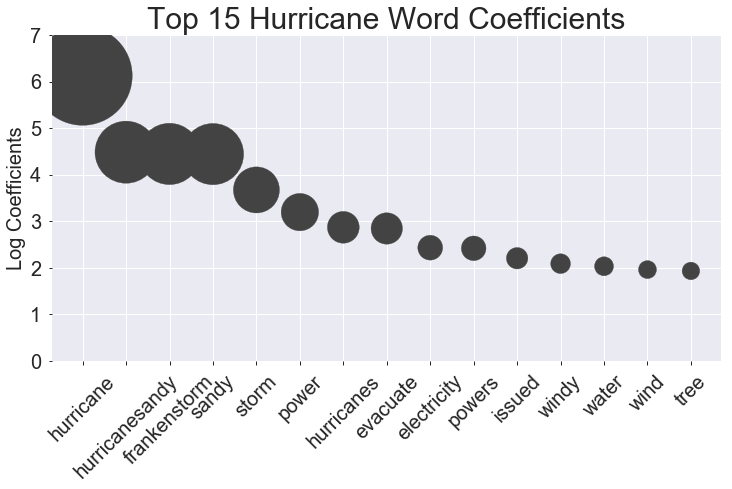

In [252]:
top_hurricane_words = cv_lg_df.sort_values(by=['hurricane_coef'], ascending=False).head(15)

s = [(3.5*n)**3 for n in top_hurricane_words['hurricane_coef']]
plt.figure(figsize=(12, 6))
plt.scatter(x = top_hurricane_words.index, y = top_hurricane_words['hurricane_coef'], s=s, color='#434343', alpha=1)
plt.title("Top 15 Hurricane Word Coefficients", fontsize = 30)
plt.ylabel("Log Coefficients", fontsize = 20)
# plt.xlabel("Hurricane Words", fontsize = 20)
plt.xticks(fontsize=20, rotation = 45)
plt.yticks(fontsize=20)
plt.ylim(0, 7);

In [198]:
cv_lg_df.sort_values(by=['tornado_coef'], ascending=False).head(15)

,hurricane_coef,off-topic_coef,tornado_coef
tornado,-4.162480,-3.895224,5.196684
oklahoma,-4.114862,-2.919352,4.064589
tornadoes,-0.822281,-2.773019,3.365962
prayforoklahoma,-0.531276,-2.950107,3.343421
moore,-2.808381,-2.085025,3.053795
oklahomastrong,-0.315569,-2.261498,2.682939
tornados,-0.167506,-2.217009,2.624020
prayformoore,-0.348144,-1.783022,2.258378
devastation,0.090725,-1.911985,2.134095
donations,-0.376416,-1.562972,2.027673


In [199]:
# Calculate the probability that the word "oklahoma" indicates a tornado tweet
(np.exp(4.064589) / (1+np.exp(4.064589)))

0.9831197892611465

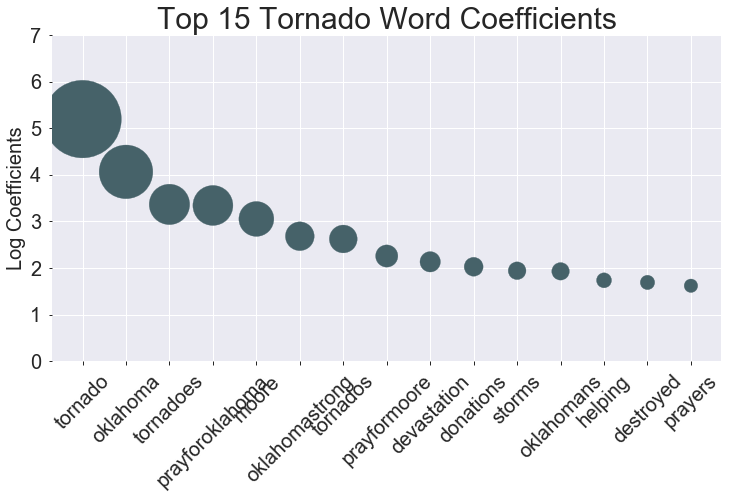

In [251]:
top_tornado_words = cv_lg_df.sort_values(by=['tornado_coef'], ascending=False).head(15)

s = [(3.5*n)**3 for n in top_tornado_words['tornado_coef']]
plt.figure(figsize=(12, 6))
plt.scatter(x = top_tornado_words.index, y = top_tornado_words['tornado_coef'], s=s, color='#466269', alpha=1)
plt.title("Top 15 Tornado Word Coefficients", fontsize = 30)
plt.ylabel("Log Coefficients", fontsize = 20)
# plt.xlabel("Tornado Words", fontsize = 15)
plt.xticks(fontsize=20, rotation = 45)
plt.yticks(fontsize=20)
plt.ylim(0, 7);

<div class="alert alert-block alert-info">
The top 15 words that appear frequently in the pipeline with a CountVectorizer and a LogisticRegression model for both "hurricane" and "tornado" were generated, and then plotted with their respective coefficients.
    <br>    
    
"Hurricanesandy", "frankenstorm", "power", "evacuate", "windy", and "water" are words that jump out for Hurricane Sandy. Based on the coefficient of 4.445786 for "frankenstorm", the appearance of that word in a tweet would indicate an 98.8% chance that the tweet is about the hurricane.

<br>
For tornado, "prayforoklahoma", "moore", "oklahomastrong", "devastation", and "donations" are all words related to the tornado that blew through Moore, Oklahoma. Based on the coefficient of 4.064589 for "oklahoma", the appearance of that word in a post would indicate an 98.3% chance that the post is about the tornado. 

<br>

"Storm" and "destroyed" are two examples of ambiguous words that may indicate either a hurricane or a tornado. The model is currently trained based on two specific instances of disasters, so the list of related words with high coefficients are confined to locations and names of the disasters. Gathering more tweets during future disasters as they occur would build a more robust corpus and model.
<br>
</div>

### Create Model - CountVectorizer and Support Vector Machines

In [230]:
# Set X and y values
X = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['tweet'].copy()
y = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['disaster'].copy()

In [231]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [232]:
# Create pipeline with CountVectorizer and Support Vector Machines
pipe_cv_svc = Pipeline([('cvec', CountVectorizer()), ('svc', SVC())])

In [236]:
pipe_cv_svc = Pipeline([('cvec', CountVectorizer(
                                                max_features=1000,
                                                min_df = 2,
                                                ngram_range = (1,3),
                                                stop_words = stop_words,
                                                tokenizer = my_tokenizer
                                                )), ('svc', SVC(gamma='auto'))])
pipe_cv_svc.fit(X_train, y_train);

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [237]:
pipe_cv_svc.score(X_train, y_train)

0.8917214912280702

In [238]:
pipe_cv_svc.score(X_test, y_test)

0.8855087358684481

In [239]:
pred = pipe_cv_svc.predict(X_test)

In [240]:
# Build a confusion matrix
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns=['pred hurricane', 'pred off-topic', 'pred tornado'], 
                     index=['actual hurricane', 'actual off-topic', 'actual tornado'])
cm_df

,pred hurricane,pred off-topic,pred tornado
actual hurricane,1135,260,0
actual off-topic,41,2270,117
actual tornado,2,137,903


In [241]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

   hurricane       0.96      0.81      0.88      1395
   off-topic       0.85      0.93      0.89      2428
     tornado       0.89      0.87      0.88      1042

    accuracy                           0.89      4865
   macro avg       0.90      0.87      0.88      4865
weighted avg       0.89      0.89      0.89      4865



### Create Model - CountVectorizer and Random Forests

In [12]:
# Set X and y values
X = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['tweet'].copy()
y = df[(df['disaster'] == 'hurricane') | (df['disaster'] == 'tornado') | (df['disaster'] == 'off-topic')]['disaster'].copy()

In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
# Create pipeline with CountVectorizer and RandomForestClassifier
pipe_cv_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier())])

In [19]:
pipe_cv_rf = Pipeline([('cvec', CountVectorizer(
                                                max_features=1000,
                                                min_df = 2,
                                                ngram_range = (1,3),
                                                stop_words = stop_words,
                                                tokenizer = my_tokenizer
                                                )), 
                       ('rf', RandomForestClassifier(
                                                     max_depth=24,
                                                     min_samples_leaf=4,
                                                     min_samples_split=3,
                                                     n_estimators=100                       
                                                     ))])
pipe_cv_rf.fit(X_train, y_train);

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
pipe_cv_rf.score(X_train, y_train)

0.9189281798245614

In [21]:
pipe_cv_rf.score(X_test, y_test)

0.9112024665981501

In [22]:
pred = pipe_cv_rf.predict(X_test)

In [23]:
# Build a confusion matrix
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns=['pred hurricane', 'pred off-topic', 'pred tornado'], 
                     index=['actual hurricane', 'actual off-topic', 'actual tornado'])
cm_df

,pred hurricane,pred off-topic,pred tornado
actual hurricane,1237,157,1
actual off-topic,58,2286,84
actual tornado,3,129,910


In [24]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

   hurricane       0.95      0.89      0.92      1395
   off-topic       0.89      0.94      0.91      2428
     tornado       0.91      0.87      0.89      1042

    accuracy                           0.91      4865
   macro avg       0.92      0.90      0.91      4865
weighted avg       0.91      0.91      0.91      4865



In [28]:
# Train model on entire corpus
pipe_cv_rf.fit(X, y);

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Import Test Tweets and Predict Using Random Forests

In [210]:
# Pull tweets from Cape Cod Tornado
tweets_df1 = pd.read_csv("../datasets/cape_cod_tornado_12.csv")
# tweets_df1.head()

,screen_name,id_str,created_at,coordinates,place,text,geo_location
0,BostonGlobe,1154116553283121152,2019-07-24 19:50:03,NaN,NaN,Governor Charlie Baker said Wednesday that state officials will seek a federal disaster declaration to support reco… https://t.co/IbVLxLIMS4,NaN
1,drjustinimel,1154116460026793984,2019-07-24 19:49:41,NaN,NaN,"Rare tornado strikes Cape Cod, Massachusetts https://t.co/n07z2uL67n",NaN
2,boston25,1154116303503970305,2019-07-24 19:49:03,NaN,NaN,Gov. Baker to seek disaster declaration for Cape Cod tornado https://t.co/UHTx4smjRV,NaN
3,PaPaShArMFbI,1154115592812548096,2019-07-24 19:46:14,NaN,NaN,High winds rip roof off hotel as rare tornado strikes Massachusetts' Cape Cod https://t.co/1xdkFsNkhm via @CBSNews,NaN
4,Fa11outS,1154112647006183424,2019-07-24 19:34:32,NaN,NaN,"Tornado hits Cape Cod leaving more than 33,000 residents without power | Fox News Here's the mainstream with that m… https://t.co/GGgWGYR6hk",NaN


In [211]:
# Pull tweets from Cape Cod Tornado
tweets_df2 = pd.read_csv("../datasets/cape_cod_tornado_13.csv")
# tweets_df2.head()

,screen_name,id_str,created_at,coordinates,place,text,geo_location
0,StebsClutchShot,1154122881862971392,2019-07-24 20:15:12,NaN,NaN,"So, I survived a tornado yesterday. What did you do? #TornadoTuesday #MyLifeIsAverage https://t.co/bmnR8eHOUw",NaN
1,BCBSMA,1154122777806479365,2019-07-24 20:14:47,NaN,NaN,"In response to recent severe storms and tornado activity on parts of Cape Cod, Blue Cross Blue Shield of Massachuse… https://t.co/ZjBAL9SmTK",NaN
2,wbznewsradio,1154122752628076544,2019-07-24 20:14:41,NaN,NaN,"NWS says the first tornado started as a waterspout that came ashore west of Kalmus just before noon, and caused ""si… https://t.co/Kunr2AXAjF",NaN
3,WGME,1154122749549469696,2019-07-24 20:14:40,NaN,NaN,Crazy video of a Tornado that swept through Cape Cod yesterday! A man working on a sailboat when a strong storm ble… https://t.co/NIG8g84B70,NaN
4,BreakinNewz01,1154122661439705089,2019-07-24 20:14:19,NaN,NaN,"JUST IN: 2 tornadoes touched down on Cape Cod Tuesday, NWS confirms https://t.co/D2vdUxJMiB https://t.co/QzjOH7HcYf",NaN


In [262]:
tweets_df2.dtypes

screen_name     object
id_str          int64 
created_at      object
coordinates     object
place           object
text            object
geo_location    object
dtype: object

In [212]:
# Combine Data
tweets_df = pd.concat([tweets_df1, tweets_df2], ignore_index=True)

tweets_df.shape

(825, 7)

In [213]:
tweets_df['pred'] = pred = pipe_cv_rf.predict(tweets_df['text'])

In [215]:
tweets_df.pred.value_counts()

tornado      673
off-topic    144
hurricane    8  
Name: pred, dtype: int64

In [216]:
# Referenced the following link to see how to display all the text
# https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
pd.set_option('display.max_colwidth', -1)

In [217]:
tweets_df[tweets_df["pred"] == "hurricane"]["text"]

222    #Cleanup efforts are underway across Cape Cod after a power #storm raged through the southern portion of the region… https://t.co/x2gjXf2bKL
352    Power remains out in large areas of Cape Cod that were pounded in yesterday's storm\n https://t.co/iSL0Z4FdNx                               
396    "This is insane!"\n\nCorey Smith was alone in the water off Chatham when he captured video of the storm's power.… https://t.co/qBHJqsEn0F   
469    Severe storms have continued to hammer the East Coast in the wake of the heat wave, with flash flooding, hundreds o… https://t.co/FU7FMI7yEE
560    @MollyJongFast Then he's in the middle of tornado hurricane tsunami cyclone and a snowstorm all at once.                                    
577    @ChatByCC @realDonaldTrump Like a tornado or hurricane or tropical depression.... https://t.co/SnfSiODYF1                                   
592    Ok, I've tried to be the lady I was raised to be, but that hearing was a trainwreck in the middle of a hu

In [218]:
tweets_df.isnull().sum()

screen_name     0  
id_str          0  
created_at      0  
coordinates     820
place           797
text            0  
geo_location    820
pred            0  
dtype: int64

In [219]:
geo_tweets_df = tweets_df[(tweets_df["pred"] == "tornado") & ~(tweets_df["coordinates"].isnull())]

In [221]:
# How to parse out a dictionary from a string
# https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary

geo_tweets_df['geo_location_dict'] = [json.loads(g.replace("'", "\"")) for g in geo_tweets_df['geo_location']]

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [223]:
geo_tweets_df["latitude"] = [g['coordinates'][0] for g in geo_tweets_df["geo_location_dict"]]

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [224]:
geo_tweets_df["longitude"] = [g['coordinates'][1] for g in geo_tweets_df["geo_location_dict"]]

C:\Users\tengw\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [226]:
# Save the tweets with geolocation data dataframe to a csv file
geo_tweets_df.to_csv('../datasets/geo_tweets.csv', index=False)

### Import Test Tweets and Predict Using Logistic Regression

In [201]:
# Pull tweets from Cape Cod Tornado
tweets_df1 = pd.read_csv("../datasets/cape_cod_tornado_12.csv")
# tweets_df1.head()

,screen_name,id_str,created_at,coordinates,place,text,geo_location
0,BostonGlobe,1154116553283121152,2019-07-24 19:50:03,NaN,NaN,Governor Charlie Baker said Wednesday that sta...,NaN
1,drjustinimel,1154116460026793984,2019-07-24 19:49:41,NaN,NaN,"Rare tornado strikes Cape Cod, Massachusetts h...",NaN
2,boston25,1154116303503970305,2019-07-24 19:49:03,NaN,NaN,Gov. Baker to seek disaster declaration for Ca...,NaN
3,PaPaShArMFbI,1154115592812548096,2019-07-24 19:46:14,NaN,NaN,High winds rip roof off hotel as rare tornado ...,NaN
4,Fa11outS,1154112647006183424,2019-07-24 19:34:32,NaN,NaN,"Tornado hits Cape Cod leaving more than 33,000...",NaN


In [202]:
# Pull tweets from Cape Cod Tornado
tweets_df2 = pd.read_csv("../datasets/cape_cod_tornado_13.csv")
# tweets_df2.head()

,screen_name,id_str,created_at,coordinates,place,text,geo_location
0,StebsClutchShot,1154122881862971392,2019-07-24 20:15:12,NaN,NaN,"So, I survived a tornado yesterday. What did y...",NaN
1,BCBSMA,1154122777806479365,2019-07-24 20:14:47,NaN,NaN,In response to recent severe storms and tornad...,NaN
2,wbznewsradio,1154122752628076544,2019-07-24 20:14:41,NaN,NaN,NWS says the first tornado started as a waters...,NaN
3,WGME,1154122749549469696,2019-07-24 20:14:40,NaN,NaN,Crazy video of a Tornado that swept through Ca...,NaN
4,BreakinNewz01,1154122661439705089,2019-07-24 20:14:19,NaN,NaN,JUST IN: 2 tornadoes touched down on Cape Cod ...,NaN


In [203]:
# Combine Data
tweets_df = pd.concat([tweets_df1, tweets_df2], ignore_index=True)

tweets_df.shape

(825, 7)

In [204]:
tweets_df['pred'] = pred = pipe_cv_lg.predict(tweets_df['text'])

In [206]:
tweets_df.pred.value_counts()

tornado      636
off-topic    159
hurricane     30
Name: pred, dtype: int64

In [209]:
tweets_df[tweets_df["pred"] == "hurricane"]["text"]

12     WATCH: A man working on a sailboat when a strong storm blew through Cape Cod managed to hang on and record the dram… https://t.co/VdO8e3jggD    
44     Between Fort Greene and Southeast Queens, I lived in NYC for over three decades. I don't recall flooding in… https://t.co/PciwrymZDB            
67     .@MassGovernor tells reporters 32 thousand customers are still without power in the areas of Cape Cod hit by yester… https://t.co/X2Ko9lZzhW    
124    Downtown Chatham still has no power. Most main street businesses are closed. Lots of cleanup work is still being do… https://t.co/6SFabzrslZ    
176    Video shows the roof of the Cape Sands Inn in West Yarmouth getting blown off during the storm that brought a torna… https://t.co/G7t7ZBIleF    
222    #Cleanup efforts are underway across Cape Cod after a power #storm raged through the southern portion of the region… https://t.co/x2gjXf2bKL    
279    Wow; the most used verb for this storm https://t.co/xCVYp2Lwa6                   